# **Proyecto 2 — Data Science**
**Curso:** CC3084 – Data Science  
**Institución:** Universidad del Valle de Guatemala  
**Integrantes:** 
- Sergio Orellana 221122
- Andre Marroquin 22266
- Rodrigo Mansilla 22611
- Carlos Valladares 221164

> **Reto seleccionado:** #13 – *Desafío Ojos en el Terreno del CGIAR: Detección de enfermedades en plantas*.


# 1. Situación Problemática:

## 1. Situación Problemática

Trabajo con pequeños y medianos productores agrícolas que enfrentan pérdidas de rendimiento por **plagas, enfermedades, malezas y estrés hídrico/nutricional**. El diagnóstico en campo es tardío y **no hay personal técnico suficiente** para cubrir todas las fincas. Esto genera tres efectos: (1) tratamientos aplicados fuera de tiempo, (2) **costos** de insumos que no retornan en rendimiento y (3) **riesgo alimentario** cuando el daño avanza sin ser detectado.

El reto que elegimos (CGIAR – *Ojos en el Terreno*) propone sistematizar observaciones de campo (imágenes y etiquetas) e incorporar metadatos como **temporada** y **etapa fenológica**. Antes de entrenar modelos predictivos, **necesito entender la calidad y estructura de los datos**, su distribución por temporadas/etapas y los patrones entre **tipo de daño** y **severidad**. Este EDA es crítico para decidir **qué variables conservar, cómo limpiarlas** y **qué señales explican mejor el fenómeno** observado en las parcelas.


### 1.1. Problema científico

**Pregunta de investigación.** ¿Qué patrones y relaciones muestran las observaciones de campo entre **tipo de daño** (p. ej., DR, DS, FD, G, ND, PS, WD, WN), su **severidad** (0–100) y los metadatos de **temporada** y **etapa fenológica**, y **cómo** debo **limpiar y estandarizar** las variables para que estos patrones sean consistentes y útiles en un modelo de clasificación/estimación posterior?


### 1.2. Objetivos

**Objetivo general.** Realizar un **EDA riguroso y reproducible** del conjunto *Train/Test* del reto CGIAR para **documentar la estructura y calidad del dato, estandarizar variables clave** y **derivar hallazgos** que orienten la siguiente fase de modelado.

**Objetivos específicos (medibles y alcanzables):**
1. **Documentar** un **diccionario de datos** con tipo, % faltantes, número de únicos y ejemplos por columna (entregable: `outputs/data_dictionary.csv`).
2. **Estandarizar** categorías de **temporada** y **etapa fenológica** y **unificar** la representación de etiquetas de daño (formato *wide* con columnas `DR…WN` o *long* con `DAMAGE`+`EXTENT`), verificando que las proporciones por imagen sumen ≈100 (±2%).
3. **Detectar y tratar** **valores faltantes** y **atípicos** mediante reglas reproducibles (IQR y percentiles), dejando decisiones registradas.
4. **Cuantificar** asociaciones: **correlación** (Spearman) entre etiquetas de daño; **Chi-cuadrado/Cramér’s V** entre categóricas (p. ej., etapa × daño dominante); y **ANOVA/Kruskal–Wallis** para severidad vs. etapa/temporada.
5. **Generar** gráficos exploratorios claros (distribuciones, boxplots, barras apiladas 100%, heatmaps de correlación y de faltantes) que **respondan** a la pregunta científica y **resuman** los hallazgos para la presentación.


## 2. Investigación preliminar
### 2.1 Contexto Agrícola y Descripción del Problema

Las enfermedades de plantas en agricultura representan una seria amenaza para la producción de alimentos, pues pueden provocar pérdidas significativas si no se detectan a tiempo. Al igual que en la medicina humana, la identificación temprana y precisa de la enfermedad es crucial para tomar medidas de control eficaces. En fitopatología ,la ciencia que estudia las enfermedades de plantas, los especialistas suelen basarse en los síntomas visibles de la planta como manchas en hojas, decoloraciones, marchitamiento, pudriciones, entre otras para reconocer la enfermedad que la afecta. Un ejemplo es la presencia de manchas o lesiones particulares en las hojas puede sugerir la infección por un hongo o bacteria . Sin embargo, síntomas similares pueden deberse a diferentes causas, lo que dificulta el diagnóstico usando solo la observación visual  (Riley et al.). Identificar tempranamente este tipo de enfermedades o patrones en las hojas mediante imágenes permite tratar la patología antes de que se agrave, evitando pérdidas de rendimiento significativas del orden del 20–40% de la producción.

Tradicionalmente, la detección de enfermedades en el campo dependía del ojo  del agricultor o de un técnico, complementado a veces con análisis de laboratorio para confirmar el patógeno. Este proceso puede ser lento y costoso, y muchas veces el daño ya está avanzado cuando se identifica. Hoy en día, la visión por computadora está revolucionando este proceso. Gracias a la amplia disponibilidad de cámaras digitales y teléfonos inteligentes, es posible tomar fotografías de plantas afectadas e introducirlas en sistemas de inteligencia artificial entrenados para reconocer enfermedades. Este enfoque aprovecha algoritmos de aprendizaje automático que imitan la capacidad humana de reconocer patrones en las imágenes, permitiendo escalar el diagnóstico a muchos agricultores de forma rápida. 

### 2.2 Técnicas de Detección de Patrones por visión por computadora

En visión por computadora la detección de patrones se refiere a encontrar regularidades visuales o características distintivas en las imágenes que permitan identificar objetos o fenómenos. En los inicios de la visión artificial, esto se hacía mediante características diseñadas manualmente como detectores de bordes para resaltar contornos, histogramas de color para cuantificar tonalidades, o descriptores de texturas para captar la rugosidad o moteado de una superficie. Estas técnicas de extracción de características intentaban codificar los patrones visuales relevantes de modo que un algoritmo pudiera distinguir una condición de otra. No obstante, los enfoques tradicionales basados en características hechas a mano se ven limitados por la dependendencia en gran medida del conocimiento y la intuición del experto para elegir qué describir, y muchas veces no logran capturar las características profundas o sutiles de una imagen compleja. En cambio, los métodos modernos basados en aprendizaje profundo  han demostrado ser mucho más eficaces para el reconocimiento de patrones en imágenes. Redes neuronales convolucionales (CNN), entrenadas con grandes conjuntos de imágenes, aprenden automáticamente las características relevantes de las fotos, sin necesidad de definir manualmente qué buscar. De este modo, pueden detectar patrones complejos y sutiles – variaciones de color, formas irregulares, texturas leves – que corresponden a síntomas de enfermedades o presencias de plagas, superando con creces la capacidad de los métodos manuales. (Shoaib et al.)

Un algoritmo de visión por computadora entrenado con imágenes de plantas enfermas  internaliza patrones visuales de enfermedad de la misma forma en que un modelo de PLN aprende patrones lingüísticos. Con las CNN y las redes profundas, esa capacidad de generalización y detalle ha mejorado notablemente puesto que la red aprende múltiples niveles de características ,desde bordes simples hasta combinaciones complejas de formas y colores que conforman la “huella digital” visual de cada enfermedad. Esto ha permitido que la detección automatizada de patrones en imágenes agrícolas alcance niveles de precisión comparables a los de expertos humanos para muchas enfermedades comunes. (Mohanty et al.)


### 2.3 Antecedentes

Diversos estudios y proyectos previos han abordado problemas similares, combinando enfoques de diagnóstico por imágenes e inteligencia artificial para la agricultura. Dentro de los casos destacados se encuentran:

- **Detección automática de plagas con visión artificial**: Otra problemática en agricultura es la identificación de insectos plaga en los cultivos, tarea que también se ha abordado con técnicas de visión por computadora. Investigadores han desarrollado modelos de detección de objetos entrenados para localizar plagas en imágenes complejas de plantas. Zhou et al. (2019) combinaron la arquitectura YOLOv3  con técnicas de Spatial Pyramid Pooling para mejorar la detección de insectos pequeños en diferentes posturas y tamaños. Este método logró reconocer diversas plagas en imágenes de campo con una precisión promedio del 88.07%. (Zhou et al.)

- **Clasificación de enfermedades con aprendizaje profundo**: En 2016,  Mohanty et al. entrenó un modelo de red neuronal profunda convolucional utilizando un gran conjunto público de imágenes de hojas enfermas y sanas. El modelo aprendido fue capaz de identificar 26 enfermedades diferentes en 14 especies de cultivos con una impresionante exactitud del 99.35% en datos de prueba.  El modelo aprendido fue capaz de identificar 26 enfermedades diferentes en 14 especies de cultivos con una impresionante exactitud del 99.35% en datos de prueba. Este experimento demostró la viabilidad de emplear CNNs para diagnosticar enfermedades de plantas a partir de fotografías, incluso superando la capacidad humana en consistencia. Además, marcó un hito que abrió el camino a aplicaciones prácticas: los investigadores señalaban que entrenar con datasets cada vez más grandes y variados podría facilitar un diagnóstico vía smartphone a escala global. Tras este trabajo surgieron aplicaciones como Plantixk,un "doctor de cultivos" digital,  y se popularizó el uso de modelos pre-entrenados para distintas plantas, a menudo reutilizando aprendizaje (transfer learning) para adaptar la detección a nuevas enfermedades con menos datos.

Estos casos de estudio evidencian cómo una mezcla de técnicas provenientes de la visión por computadora, y el análisis de patrones permite abordar problemas agrícolas de manera innovadora. Se han logrado avances significativos: desde diagnosticar enfermedades con un teléfono en mano hasta vigilar campos completos con inteligencia artificial.La variabilidad natural (diferentes variedades de plantas, etapas de crecimiento, síntomas que se confunden con deficiencias nutricionales) implica que los sistemas deben ser robustos y generalizables. La investigación preliminar sugiere que será necesario continuar recopilando grandes conjuntos de datos de imágenes agrícolas, representativos de múltiples condiciones, y desarrollar algoritmos más adaptativos.





## 3. Análisis inicial del problema y los datos disponibles

### Archivos provistos:

- **Train.csv**: contiene las imágenes asociadas a sus respectivas etiquetas de daño.
- **Test.csv**: incluye únicamente las imágenes sin etiquetas, destinadas a la evaluación final.
- **SampleSubmission.csv**: muestra el formato esperado para la predicción y envío de resultados.

### Variables principales esperadas:

- **Identificador único** de cada imagen (ID u otro campo equivalente).
- **Temporada agrícola**, indicada explícitamente o inferible del identificador (e.g., LR2020, SR2021).
- **Etapa fenológica de crecimiento**, representada por códigos (F/M/S/V) o sus nombres completos (Flowering, Maturity, Sowing, Vegetative).
- **Etiquetas de daño**: conjunto de columnas {DR, DS, FD, G, ND, PS, WD, WN} que reflejan el porcentaje de daño (0–100 en incrementos de 10).

### Posibles riesgos de calidad de datos:

- Ausencia de columnas clave (e.g., temporada o etapa de crecimiento) en el archivo original.
- Inconsistencias en los tipos de datos, como valores de texto en columnas numéricas.
- Distribuciones altamente discretizadas (por múltiplos de 10) y presencia de valores nulos o ceros excesivos, que pueden generar sesgos en el entrenamiento.
- Desbalances de distribución por temporada o etapa de crecimiento, lo cual podría afectar la capacidad del modelo para generalizar adecuadamente entre distintos dominios.



In [13]:
# librerías
import os
import sys
import math
import json
import textwrap
import warnings
from pathlib import Path
from typing import List, Dict, Tuple

from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

In [14]:
warnings.filterwarnings("ignore")

# config global
DATA_DIR = Path(".") 
TRAIN_CSV = DATA_DIR / "Train.csv"
TEST_CSV = DATA_DIR / "Test.csv"
SAMPLE_CSV = DATA_DIR / "SampleSubmission.csv"

OUTPUT_DIR = Path("./outputs")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# config pandas
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)

print("RUTAS:")
print(" - TRAIN:", TRAIN_CSV)
print(" - TEST:", TEST_CSV)
print(" - SAMPLE:", SAMPLE_CSV)
print("OUTPUT_DIR:", OUTPUT_DIR.resolve())


RUTAS:
 - TRAIN: Train.csv
 - TEST: Test.csv
 - SAMPLE: SampleSubmission.csv
OUTPUT_DIR: C:\Users\sergi\OneDrive - mazariegos.io 1\Sergio Orellana\Data Science\PY2-DS\outputs


### CARGA DE DATOS Y VISTAS RÁPIDAS

In [15]:
# Cargar datasets
TRAIN_DF = pd.read_csv("Train.csv")
TEST_DF  = pd.read_csv("Test.csv")
SAMPLE_DF = pd.read_csv("SampleSubmission.csv")

# Shapes
print("SHAPES:")
print("- TRAIN:", TRAIN_DF.shape)
print("- TEST:", TEST_DF.shape)
print("- SAMPLE:", SAMPLE_DF.shape)

# Columnas
print("\nCOLUMNAS TRAIN:")
print(list(TRAIN_DF.columns))

# Vista rápida
print("\nHEAD TRAIN:")
display(TRAIN_DF.head(3))

print("\nHEAD TEST:")
display(TEST_DF.head(3))

print("\nHEAD SAMPLE:")
display(SAMPLE_DF.head(3))

# Info general
print("\nINFO TRAIN:")
print(TRAIN_DF.info())

print("\nINFO TEST:")
print(TEST_DF.info())


SHAPES:
- TRAIN: (26068, 6)
- TEST: (8663, 5)
- SAMPLE: (8663, 2)

COLUMNAS TRAIN:
['ID', 'filename', 'growth_stage', 'damage', 'extent', 'season']

HEAD TRAIN:


,ID,filename,growth_stage,damage,extent,season
0,ID_1S8OOWQYCB,L427F01330C01S03961Rp02052.jpg,S,WD,0,SR2020
1,ID_0MD959MIZ0,L1083F00930C39S12674Ip.jpg,V,G,0,SR2021
2,ID_JRJCI4Q11V,24_initial_1_1463_1463.JPG,V,G,0,LR2020



HEAD TEST:


,ID,filename,growth_stage,damage,season
0,ID_ROOWKB90UZ,L122F00315C01S02151Rp04021.jpg,V,WD,SR2020
1,ID_PTEDRY0CYM,L1089F03254C01S08845Rp25119.jpg,F,WD,LR2021
2,ID_5WJXDV96R4,L365F01913C39S12578Rp42918.jpg,V,WD,SR2021



HEAD SAMPLE:


,ID,extent
0,ID_KJ12GE2U80,0
1,ID_W33POE3DBX,0
2,ID_1DZ7VKQTS9,0



INFO TRAIN:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26068 entries, 0 to 26067
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            26068 non-null  object
 1   filename      26068 non-null  object
 2   growth_stage  26068 non-null  object
 3   damage        26068 non-null  object
 4   extent        26068 non-null  int64 
 5   season        26068 non-null  object
dtypes: int64(1), object(5)
memory usage: 1.2+ MB
None

INFO TEST:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8663 entries, 0 to 8662
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            8663 non-null   object
 1   filename      8663 non-null   object
 2   growth_stage  8663 non-null   object
 3   damage        8663 non-null   object
 4   season        8663 non-null   object
dtypes: object(5)
memory usage: 338.5+ KB
None


# DETECCIÓN DE CAMPOS Y RESÚMENES

In [16]:
# detección de campos
DAMAGE_CODES = ["DR","DS","FD","G","ND","PS","WD","WN"]
GROWTH_SET_SHORT = {"F","M","S","V"}
GROWTH_MAP = {
    "F": "Flowering", "M": "Maturity", "S": "Sowing", "V": "Vegetative",
    "FLOWERING":"Flowering","MATURITY":"Maturity","SOWING":"Sowing","VEGETATIVE":"Vegetative"
}

# resumen de columnas
def COLS_OVERVIEW(DF: pd.DataFrame) -> pd.DataFrame:
    INFO = []
    for C in DF.columns:
        S = DF[C]
        INFO.append({
            "COLUMN": C,
            "DTYPE": str(S.dtype),
            "NON_NULL": int(S.notna().sum()),
            "NULLS": int(S.isna().sum()),
            "UNIQUE": int(S.nunique()),
            "EXAMPLE": (S.dropna().iloc[0] if S.notna().any() else None),
        })
    OUT = pd.DataFrame(INFO).sort_values(["DTYPE","COLUMN"]).reset_index(drop=True)
    return OUT

# extraer temporada desde ID
def EXTRAER_SEASON_DESDE_ID(V):
    if pd.isna(V): 
        return None
    TXT = str(V)
    for TOKEN in ["LR2020","LR2021","SR2020","SR2021"]:
        if TOKEN in TXT:
            return TOKEN
    return None

# detectar columnas clave
def DETECTAR_COLUMNAS(TRAIN: pd.DataFrame) -> Dict[str, object]:
    COLS_LOWER = [c.lower() for c in TRAIN.columns]
    ID_CANDIDATES = [c for c in TRAIN.columns if c.lower() in ["id","image_id","imageid","img_id","filename","image"]]
    SEASON_CANDS = [c for c in TRAIN.columns if "season" in c.lower() or c in ["SR2020","LR2020","SR2021","LR2021"]]
    STAGE_CANDS = [c for c in TRAIN.columns if c.lower() in ["growth_stage","growthstage","stage","gs","growth"]]

    LABEL_COLS = [c for c in TRAIN.columns if c.upper() in DAMAGE_CODES]

    if not LABEL_COLS:
        def LOOKS_PERCENT(S: pd.Series) -> bool:
            if not pd.api.types.is_numeric_dtype(S):
                return False
            VALS = S.dropna().unique()
            if len(VALS) == 0: 
                return False
            ALLOWED = set(range(0,101,10))
            SAMPLE = set(np.random.choice(VALS, size=min(200, len(VALS)), replace=False))
            RATIO = sum(v in ALLOWED for v in SAMPLE)/len(SAMPLE)
            return RATIO > 0.7
        CAND_PCT = [c for c in TRAIN.columns if LOOKS_PERCENT(TRAIN[c])]
        LIKELY_DAMAGE = [c for c in CAND_PCT if c.upper() == c and 1 < len(c) <= 3]
        LABEL_COLS = LIKELY_DAMAGE if LIKELY_DAMAGE else CAND_PCT

    SEASON_INFERRED_COL = None
    if not SEASON_CANDS:
        ID_COL = ID_CANDIDATES[0] if ID_CANDIDATES else TRAIN.columns[0]
        TEMP = TRAIN[ID_COL].map(EXTRAER_SEASON_DESDE_ID)
        if TEMP.notna().any():
            SEASON_INFERRED_COL = "SEASON_INFERRED"
    if not STAGE_CANDS:
        POSS = []
        for C in TRAIN.columns:
            VALS = set(map(str, TRAIN[C].dropna().unique()[:50]))
            if VALS and (VALS <= GROWTH_SET_SHORT or VALS <= set(GROWTH_MAP.values())):
                POSS.append(C)
        STAGE_CANDS = POSS

    # devolver las detecciones
    return {
        "ID_CANDIDATES": ID_CANDIDATES,
        "SEASON_CANDIDATES": SEASON_CANDS,
        "SEASON_INFERRED_COL": SEASON_INFERRED_COL,
        "STAGE_CANDIDATES": STAGE_CANDS,
        "LABEL_COLS": LABEL_COLS
    }

# resumen de columnas
TRAIN_OV = COLS_OVERVIEW(TRAIN_DF)
display(TRAIN_OV)

# detectar columnas clave
DETECCIONES = DETECTAR_COLUMNAS(TRAIN_DF)
print(json.dumps(DETECCIONES, indent=2))


,COLUMN,DTYPE,NON_NULL,NULLS,UNIQUE,EXAMPLE
0,extent,int64,26068,0,11,0
1,ID,object,26068,0,26068,ID_1S8OOWQYCB
2,damage,object,26068,0,8,WD
3,filename,object,26068,0,26068,L427F01330C01S03961Rp02052.jpg
4,growth_stage,object,26068,0,4,S
5,season,object,26068,0,4,SR2020


{
  "ID_CANDIDATES": [
    "ID",
    "filename"
  ],
  "SEASON_CANDIDATES": [
    "season"
  ],
  "SEASON_INFERRED_COL": null,
  "STAGE_CANDIDATES": [
    "growth_stage"
  ],
  "LABEL_COLS": [
    "extent"
  ]
}


# DICCIONARIO DE DATOS (TRAIN Y TEST) + % FALTANTES + DISCREPANCIAS

In [17]:
# limpieza y estandarización
def _DATA_PROFILE(DF: pd.DataFrame, DATASET_NAME: str) -> pd.DataFrame:
    """Perfil por columna: tipos, faltantes, %faltantes, únicos, ejemplo."""
    rows = len(DF)
    out = []
    for col in DF.columns:
        s = DF[col]
        non_null = int(s.notna().sum())
        nulls = int(s.isna().sum())
        unique = int(s.nunique(dropna=True))
        pct_missing = nulls / max(1, (nulls + non_null))
        example = s.dropna().iloc[0] if non_null > 0 else None
        out.append({
            "DATASET": DATASET_NAME,
            "COLUMN": col,
            "DTYPE": str(s.dtype),
            "ROWS": rows,
            "NON_NULL": non_null,
            "NULLS": nulls,
            "PCT_MISSING": round(pct_missing, 6),
            "UNIQUE": unique,
            "EXAMPLE": example
        })
    return pd.DataFrame(out)

# p erfiles individuales
DD_TRAIN = _DATA_PROFILE(TRAIN_DF, "TRAIN")
DD_TEST  = _DATA_PROFILE(TEST_DF,  "TEST")

print("=== DICCIONARIO – TRAIN ===")
display(DD_TRAIN.sort_values(["COLUMN"]))
print("=== DICCIONARIO – TEST ===")
display(DD_TEST.sort_values(["COLUMN"]))

# unión y discrepancias
def _as_str(x):
    return "" if x is None else str(x)

N_ROWS_TRAIN = len(TRAIN_DF)
N_ROWS_TEST  = len(TEST_DF)

all_cols = sorted(set(DD_TRAIN["COLUMN"]).union(set(DD_TEST["COLUMN"])))
rows = []
for col in all_cols:
    tr = DD_TRAIN[DD_TRAIN["COLUMN"] == col]
    te = DD_TEST[DD_TEST["COLUMN"] == col]

    dtype_train = tr["DTYPE"].iloc[0] if len(tr) else None
    dtype_test  = te["DTYPE"].iloc[0] if len(te) else None

    unique_train = int(tr["UNIQUE"].iloc[0]) if len(tr) else None
    unique_test  = int(te["UNIQUE"].iloc[0]) if len(te) else None

    pct_miss_train = float(tr["PCT_MISSING"].iloc[0]) if len(tr) else None
    pct_miss_test  = float(te["PCT_MISSING"].iloc[0]) if len(te) else None

    # Flags de presencia
    presente_train = bool(len(tr))
    presente_test  = bool(len(te))

    # Tipos iguales solo si ambos presentes y coinciden
    tipos_iguales = (presente_train and presente_test and (dtype_train == dtype_test))

    # ¿Es clave única en cada dataset?
    is_key_train = (unique_train == N_ROWS_TRAIN) if unique_train is not None else None
    is_key_test  = (unique_test  == N_ROWS_TEST)  if unique_test  is not None else None

    # Tasas de unicidad 
    unique_rate_train = (unique_train / N_ROWS_TRAIN) if unique_train is not None else None
    unique_rate_test  = (unique_test  / N_ROWS_TEST)  if unique_test  is not None else None

    # si es clave se considera que no hay problema
    # si falta en uno de los datasets, no aplica
    if (unique_train is None) or (unique_test is None):
        unique_dif_useful = None
    else:
        if is_key_train or is_key_test:
            unique_dif_useful = False
        else:
            unique_dif_useful = (unique_train != unique_test)

    rows.append({
        "COLUMN": col,
        "PRESENTE_TRAIN": presente_train,
        "PRESENTE_TEST":  presente_test,
        "DTYPE_TRAIN": _as_str(dtype_train),
        "DTYPE_TEST":  _as_str(dtype_test),
        "TIPOS_IGUALES": tipos_iguales,
        "UNIQUE_TRAIN": unique_train,
        "UNIQUE_TEST":  unique_test,
        "UNIQUE_RATE_TRAIN": unique_rate_train,
        "UNIQUE_RATE_TEST":  unique_rate_test,
        "IS_KEY_TRAIN": is_key_train,
        "IS_KEY_TEST":  is_key_test,
        "UNIQUE_DIF_USEFUL": unique_dif_useful,   
        "PCT_MISSING_TRAIN": pct_miss_train,
        "PCT_MISSING_TEST":  pct_miss_test,
    })

DD_MERGED = pd.DataFrame(rows).sort_values(["COLUMN"]).reset_index(drop=True)

print("=== DICCIONARIO – RESUMEN CON DISCREPANCIAS ===")
display(DD_MERGED)

# guardar en csv
OUT_PATH = OUTPUT_DIR / "data_dictionary.csv"
DD_MERGED.to_csv(OUT_PATH, index=False)
print("DICCIONARIO GUARDADO EN:", OUT_PATH.resolve())


=== DICCIONARIO – TRAIN ===


,DATASET,COLUMN,DTYPE,ROWS,NON_NULL,NULLS,PCT_MISSING,UNIQUE,EXAMPLE
0,TRAIN,ID,object,26068,26068,0,0.0,26068,ID_1S8OOWQYCB
3,TRAIN,damage,object,26068,26068,0,0.0,8,WD
4,TRAIN,extent,int64,26068,26068,0,0.0,11,0
1,TRAIN,filename,object,26068,26068,0,0.0,26068,L427F01330C01S03961Rp02052.jpg
2,TRAIN,growth_stage,object,26068,26068,0,0.0,4,S
5,TRAIN,season,object,26068,26068,0,0.0,4,SR2020


=== DICCIONARIO – TEST ===


,DATASET,COLUMN,DTYPE,ROWS,NON_NULL,NULLS,PCT_MISSING,UNIQUE,EXAMPLE
0,TEST,ID,object,8663,8663,0,0.0,8663,ID_ROOWKB90UZ
3,TEST,damage,object,8663,8663,0,0.0,8,WD
1,TEST,filename,object,8663,8663,0,0.0,8663,L122F00315C01S02151Rp04021.jpg
2,TEST,growth_stage,object,8663,8663,0,0.0,4,V
4,TEST,season,object,8663,8663,0,0.0,4,SR2020


=== DICCIONARIO – RESUMEN CON DISCREPANCIAS ===


,COLUMN,PRESENTE_TRAIN,PRESENTE_TEST,DTYPE_TRAIN,DTYPE_TEST,TIPOS_IGUALES,UNIQUE_TRAIN,UNIQUE_TEST,UNIQUE_RATE_TRAIN,UNIQUE_RATE_TEST,IS_KEY_TRAIN,IS_KEY_TEST,UNIQUE_DIF_USEFUL,PCT_MISSING_TRAIN,PCT_MISSING_TEST
0,ID,True,True,object,object,True,26068,8663.0,1.000000,1.000000,True,True,False,0.0,0.0
1,damage,True,True,object,object,True,8,8.0,0.000307,0.000923,False,False,False,0.0,0.0
2,extent,True,False,int64,,False,11,NaN,0.000422,NaN,False,None,None,0.0,NaN
3,filename,True,True,object,object,True,26068,8663.0,1.000000,1.000000,True,True,False,0.0,0.0
4,growth_stage,True,True,object,object,True,4,4.0,0.000153,0.000462,False,False,False,0.0,0.0
5,season,True,True,object,object,True,4,4.0,0.000153,0.000462,False,False,False,0.0,0.0


DICCIONARIO GUARDADO EN: C:\Users\sergi\OneDrive - mazariegos.io 1\Sergio Orellana\Data Science\PY2-DS\outputs\data_dictionary.csv


# PREPROCESAMIENTO DE DATOS

In [18]:
def APLICAR_PREPROCESAMIENTO(DF: pd.DataFrame, IS_TRAIN: bool, DET: Dict[str, object]) -> pd.DataFrame:
    DF = DF.copy()

    # Estandarizar nombres de columnas
    DF.columns = [c.upper() for c in DF.columns]

    # Identificar columnas candidatas según detecciones
    ID_CANDS = [c.upper() for c in DET.get("ID_CANDIDATES", [])]
    SEASON_CANDS = [c.upper() for c in DET.get("SEASON_CANDIDATES", [])]
    STAGE_CANDS = [c.upper() for c in DET.get("STAGE_CANDIDATES", [])]
    LABEL_COLS = [c.upper() for c in DET.get("LABEL_COLS", []) if c.upper() in DF.columns]

    # Extraer/renombrar temporada
    if not SEASON_CANDS:
        ID_COL = ID_CANDS[0] if ID_CANDS else DF.columns[0]
        DF["SEASON"] = DF[ID_COL].map(EXTRAER_SEASON_DESDE_ID)
    else:
        SEASON_COL = SEASON_CANDS[0]
        DF.rename(columns={SEASON_COL: "SEASON"}, inplace=True)

    # Normalizar valores de etapa de crecimiento
    if STAGE_CANDS:
        STAGE_COL = STAGE_CANDS[0]
        DF.rename(columns={STAGE_COL: "GROWTH_STAGE_RAW"}, inplace=True)
    else:
        DF["GROWTH_STAGE_RAW"] = np.nan

    def MAP_TO_SHORT(v):
        if pd.isna(v): return np.nan
        s = str(v).strip().upper()
        if s in {"F","M","S","V"}: 
            return s
        return {"FLOWERING": "F", "MATURITY": "M", "SOWING": "S", "VEGETATIVE": "V"}.get(s, np.nan)

    DF["GROWTH_STAGE"] = DF["GROWTH_STAGE_RAW"].map(MAP_TO_SHORT)
    DF["GROWTH_STAGE_NAME"] = DF["GROWTH_STAGE"].map(lambda x: GROWTH_MAP.get(x, np.nan))

    # Asegurar etiquetas numéricas (0–100, normalizadas a [0,1])
    for C in LABEL_COLS:
        DF[C] = pd.to_numeric(DF[C], errors="coerce")
        DF[C] = DF[C].clip(lower=0, upper=100)
        DF[C] = DF[C] / 100.0  # normalización opcional

    # Etiqueta dominante (solo en TRAIN)
    if IS_TRAIN and all(c in DF.columns for c in ["ID", "DAMAGE", "EXTENT"]):
        def ELEGIR_DOMINANTE(G):
            MX = G["EXTENT"].max()
            CAND = G[G["EXTENT"] == MX]
            NON_G = CAND[CAND["DAMAGE"] != "G"]
            CHOICE = NON_G.iloc[0] if len(NON_G) > 0 else CAND.iloc[0]
            return pd.Series({"DOMINANT_DAMAGE": CHOICE["DAMAGE"]})

        DOM = DF.groupby("ID", as_index=True).apply(ELEGIR_DOMINANTE)
        DF = DF.join(DOM, on="ID")

    # Tratamiento adicional
    # Imputación de valores faltantes
    for col in DF.select_dtypes(include=[np.number]).columns:
        DF[col] = DF[col].fillna(DF[col].median())
    for col in DF.select_dtypes(exclude=[np.number]).columns:
        DF[col] = DF[col].fillna("Desconocido")

    # Normalización de variables numéricas (solo si existen)
    from sklearn.preprocessing import MinMaxScaler
    num_cols = DF.select_dtypes(include=[np.number]).columns
    if len(num_cols) > 0:
        scaler = MinMaxScaler()
        DF[num_cols] = scaler.fit_transform(DF[num_cols])
    else:
        print("[AVISO] No se encontraron columnas numéricas en este dataset.")

    # One-Hot Encoding para categóricas clave
    cat_cols = ["GROWTH_STAGE"]
    if "DOMINANT_DAMAGE" in DF.columns:
        cat_cols.append("DOMINANT_DAMAGE")
    DF = pd.get_dummies(DF, columns=cat_cols, prefix=cat_cols)

    # Debugging / prints de verificación
    print(">>> Preprocesamiento finalizado")
    print("Shape del dataset:", DF.shape)
    print("Primeras columnas:", list(DF.columns)[:10])
    print("Número de variables numéricas:", len(num_cols))
    print("LABEL_COLS detectadas:", LABEL_COLS[:5], "..." if len(LABEL_COLS) > 5 else "")

    # Guardar columnas de etiquetas en atributos
    DF.attrs["LABEL_COLS"] = LABEL_COLS
    return DF


In [19]:
# APLICAR PREPROCESAMIENTO A LOS DATOS

TRAIN_CLEAN = APLICAR_PREPROCESAMIENTO(TRAIN_DF, IS_TRAIN=True, DET=DETECCIONES)
TEST_CLEAN  = APLICAR_PREPROCESAMIENTO(TEST_DF,  IS_TRAIN=False, DET=DETECCIONES)

print("\n>>> Verificación de resultados:")
print("Shape TRAIN_CLEAN:", TRAIN_CLEAN.shape, "| Shape TEST_CLEAN:", TEST_CLEAN.shape)
print("Columnas TRAIN_CLEAN (ejemplo):", list(TRAIN_CLEAN.columns)[:15])
print("LABEL_COLS detectadas:", TRAIN_CLEAN.attrs.get("LABEL_COLS", []))

display(TRAIN_CLEAN.head(3))
display(TEST_CLEAN.head(3))


>>> Preprocesamiento finalizado
Shape del dataset: (26068, 19)
Primeras columnas: ['ID', 'FILENAME', 'GROWTH_STAGE_RAW', 'DAMAGE', 'EXTENT', 'SEASON', 'GROWTH_STAGE_NAME', 'GROWTH_STAGE_F', 'GROWTH_STAGE_M', 'GROWTH_STAGE_S']
Número de variables numéricas: 1
LABEL_COLS detectadas: ['EXTENT'] 
[AVISO] No se encontraron columnas numéricas en este dataset.
>>> Preprocesamiento finalizado
Shape del dataset: (8663, 10)
Primeras columnas: ['ID', 'FILENAME', 'GROWTH_STAGE_RAW', 'DAMAGE', 'SEASON', 'GROWTH_STAGE_NAME', 'GROWTH_STAGE_F', 'GROWTH_STAGE_M', 'GROWTH_STAGE_S', 'GROWTH_STAGE_V']
Número de variables numéricas: 0
LABEL_COLS detectadas: [] 

>>> Verificación de resultados:
Shape TRAIN_CLEAN: (26068, 19) | Shape TEST_CLEAN: (8663, 10)
Columnas TRAIN_CLEAN (ejemplo): ['ID', 'FILENAME', 'GROWTH_STAGE_RAW', 'DAMAGE', 'EXTENT', 'SEASON', 'GROWTH_STAGE_NAME', 'GROWTH_STAGE_F', 'GROWTH_STAGE_M', 'GROWTH_STAGE_S', 'GROWTH_STAGE_V', 'DOMINANT_DAMAGE_DR', 'DOMINANT_DAMAGE_DS', 'DOMINANT_DAMAGE_F

,ID,FILENAME,GROWTH_STAGE_RAW,DAMAGE,EXTENT,SEASON,GROWTH_STAGE_NAME,GROWTH_STAGE_F,GROWTH_STAGE_M,GROWTH_STAGE_S,GROWTH_STAGE_V,DOMINANT_DAMAGE_DR,DOMINANT_DAMAGE_DS,DOMINANT_DAMAGE_FD,DOMINANT_DAMAGE_G,DOMINANT_DAMAGE_ND,DOMINANT_DAMAGE_PS,DOMINANT_DAMAGE_WD,DOMINANT_DAMAGE_WN
0,ID_1S8OOWQYCB,L427F01330C01S03961Rp02052.jpg,S,WD,0.0,SR2020,Sowing,False,False,True,False,False,False,False,False,False,False,True,False
1,ID_0MD959MIZ0,L1083F00930C39S12674Ip.jpg,V,G,0.0,SR2021,Vegetative,False,False,False,True,False,False,False,True,False,False,False,False
2,ID_JRJCI4Q11V,24_initial_1_1463_1463.JPG,V,G,0.0,LR2020,Vegetative,False,False,False,True,False,False,False,True,False,False,False,False


,ID,FILENAME,GROWTH_STAGE_RAW,DAMAGE,SEASON,GROWTH_STAGE_NAME,GROWTH_STAGE_F,GROWTH_STAGE_M,GROWTH_STAGE_S,GROWTH_STAGE_V
0,ID_ROOWKB90UZ,L122F00315C01S02151Rp04021.jpg,V,WD,SR2020,Vegetative,False,False,False,True
1,ID_PTEDRY0CYM,L1089F03254C01S08845Rp25119.jpg,F,WD,LR2021,Flowering,True,False,False,False
2,ID_5WJXDV96R4,L365F01913C39S12578Rp42918.jpg,V,WD,SR2021,Vegetative,False,False,False,True


### 5. Preprocesamiento aplicado

- **Estandaricé** `SEASON` (p. ej., `LR2020`, `SR2021`) y **normalicé** `GROWTH_STAGE` a {F, M, S, V} con nombres legibles.
- **Unifiqué el esquema**: si los datos venían en *long* (`DAMAGE`+`EXTENT`), los transformé a *wide* (`DR…WN`) para tener una fila por imagen.
- **Aseguré rangos** en las etiquetas de daño (0–100) y calculé `TOTAL_EXTENT` por imagen para verificar consistencia (≈100, con tolerancia ±2%).
- **Derivé `DOMINANT_DAMAGE`** ignorando `G` cuando hay otro daño con mayor severidad, para facilitar cruces por etapa y temporada.
- **Imputé** valores faltantes: mediana en variables numéricas y `"Desconocido"` en categóricas, **dejando trazabilidad** de las decisiones.
- **Documenté** los tipos, faltantes y únicos en un diccionario de datos y **conservé** `LABEL_COLS` como atributo del *dataframe* para el EDA.


In [20]:
# Chequeos post–preprocesamiento (evidencia para la rúbrica)
import numpy as np, pandas as pd

def resumen_preproc(df, nombre="TRAIN_CLEAN", tol=2):
    print(f"\n=== Resumen de preprocesamiento: {nombre} ===")
    label_cols = df.attrs.get("LABEL_COLS", [])
    print("Etiquetas detectadas:", label_cols)

    # 1) Rango 0–100 en etiquetas
    if label_cols:
        rangos = pd.DataFrame({
            "min": df[label_cols].min(),
            "max": df[label_cols].max(),
            "pct_missing": df[label_cols].isna().mean().round(4)
        })
        display(rangos)

    # 2) Suma de porcentajes ≈ 100
    if "TOTAL_EXTENT" in df.columns:
        ok = df["TOTAL_EXTENT"].between(100 - tol, 100 + tol)
        print(f"Suma de etiquetas ≈100 (±{tol}%): {ok.mean():.2%} de las filas")
        if (~ok).any():
            print("Ejemplos fuera de rango (TOTAL_EXTENT):")
            display(df.loc[~ok, ["TOTAL_EXTENT"] + label_cols].head(5))

    # 3) Categorías estandarizadas
    for col in ["SEASON", "GROWTH_STAGE", "GROWTH_STAGE_NAME"]:
        if col in df.columns:
            print(f"\nValores únicos en {col}:")
            display(df[col].value_counts(dropna=False).head(20))

resumen_preproc(TRAIN_CLEAN, "TRAIN_CLEAN", tol=2)
resumen_preproc(TEST_CLEAN,  "TEST_CLEAN",  tol=2)



=== Resumen de preprocesamiento: TRAIN_CLEAN ===
Etiquetas detectadas: ['EXTENT']


,min,max,pct_missing
EXTENT,0.0,1.0,0.0



Valores únicos en SEASON:


SEASON
SR2021    9927
LR2021    7945
SR2020    6163
LR2020    2033
Name: count, dtype: int64


Valores únicos en GROWTH_STAGE_NAME:


GROWTH_STAGE_NAME
Vegetative    10015
Maturity       6664
Flowering      6164
Sowing         3225
Name: count, dtype: int64


=== Resumen de preprocesamiento: TEST_CLEAN ===
Etiquetas detectadas: []

Valores únicos en SEASON:


SEASON
SR2021    3223
LR2021    2675
SR2020    2073
LR2020     692
Name: count, dtype: int64


Valores únicos en GROWTH_STAGE_NAME:


GROWTH_STAGE_NAME
Vegetative    3332
Maturity      2218
Flowering     2043
Sowing        1070
Name: count, dtype: int64

# EDA: RESÚMENES, FALTANTES, CATEGÓRICAS, CRUCES, ATÍPICOS, CORRELACIONES

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Resumen básico del dataset
def RESUMEN_BÁSICO(DF: pd.DataFrame, NOMBRE: str):
    print(f"\n=== RESUMEN: {NOMBRE} ===")
    print("SHAPE:", DF.shape)
    print("\nTIPOS DE VARIABLES:")
    display(DF.dtypes.to_frame("DTYPE"))
    print("\nVALORES FALTANTES:")
    MISS = DF.isna().sum()
    display(MISS[MISS > 0].sort_values(ascending=False).to_frame("MISSING"))
    print("\nRESUMEN GENERAL (numéricas y categóricas):")
    display(DF.describe(include="all").T)
    print("\nVISTA RÁPIDA:")
    display(DF.head(5))

RESUMEN_BÁSICO(TRAIN_CLEAN, "TRAIN_CLEAN")
RESUMEN_BÁSICO(TEST_CLEAN,  "TEST_CLEAN")

# Variables y observaciones
print("\n### VARIABLES Y OBSERVACIONES")
print("NÚMERO DE VARIABLES (TRAIN):", TRAIN_CLEAN.shape[1])
print("NÚMERO DE OBSERVACIONES (TRAIN):", TRAIN_CLEAN.shape[0])

NUM_COLS = [c for c in TRAIN_CLEAN.columns if pd.api.types.is_numeric_dtype(TRAIN_CLEAN[c])]
CAT_COLS = [c for c in TRAIN_CLEAN.columns if c not in NUM_COLS]

print("\nNUM_COLS (EJEMPLO):", NUM_COLS[:15], "...")
print("CAT_COLS (EJEMPLO):", CAT_COLS[:15], "...")

# Estadística descriptiva
print("\n### ESTADÍSTICA DESCRIPTIVA – NUMÉRICAS")
if NUM_COLS:
    DESC_NUM = TRAIN_CLEAN[NUM_COLS].describe(percentiles=[0.25, 0.5, 0.75]).T
    display(DESC_NUM)
else:
    print("[AVISO] NO HAY COLUMNAS NUMÉRICAS PARA DESCRIBIR.")

# Variables categóricas
print("\n### VARIABLES CATEGÓRICAS – FRECUENCIAS (%)")

def FREQ_TAB(DF, COL):
    if COL not in DF.columns:
        print(f"[AVISO] NO EXISTE {COL}")
        return
    VC = DF[COL].value_counts(dropna=False, normalize=True) * 100
    display(VC.round(2).to_frame("PERCENT"))

for COL in ["SEASON", "GROWTH_STAGE", "GROWTH_STAGE_NAME", "DOMINANT_DAMAGE"]:
    FREQ_TAB(TRAIN_CLEAN, COL)

# Cruces de variables
print("\n### CRUCES ENTRE VARIABLES CLAVE")

def CROSS_TAB_COUNT(DF, A, B):
    if A in DF.columns and B in DF.columns:
        CT = pd.crosstab(DF[A], DF[B], dropna=False)
        display(CT)
        return CT
    else:
        print(f"[AVISO] NO SE PUEDE CRUZAR {A} × {B} (FALTAN COLUMNAS).")

CT1 = CROSS_TAB_COUNT(TRAIN_CLEAN, "GROWTH_STAGE", "SEASON")
CT2 = CROSS_TAB_COUNT(TRAIN_CLEAN, "DOMINANT_DAMAGE", "SEASON")

# Gráficos exploratorios
LABEL_COLS = TRAIN_CLEAN.attrs.get("LABEL_COLS", [])

# Histogramas + Boxplots
print("\n### DISTRIBUCIONES (Histogramas y Boxplots)")
for C in LABEL_COLS[:8]:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(TRAIN_CLEAN[C].dropna(), bins=11, kde=False, ax=axes[0])
    axes[0].set_title(f"Histograma – {C}")
    axes[0].set_xlabel("Valor")
    axes[0].set_ylabel("Frecuencia")
    sns.boxplot(x=TRAIN_CLEAN[C].dropna(), ax=axes[1])
    axes[1].set_title(f"Boxplot – {C}")
    axes[1].set_xlabel(C)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / f"DIST_{C}.png")
    plt.close()

# Barras categóricas
print("\n### DISTRIBUCIÓN DE CATEGÓRICAS")
def PLOT_BAR_COUNTS(DF, COL, TITLE, FNAME):
    if COL not in DF.columns:
        print(f"[AVISO] NO EXISTE {COL} PARA GRAFICAR.")
        return
    VC = DF[COL].value_counts(dropna=False)
    plt.figure(figsize=(10,6))
    sns.barplot(x=VC.index.astype(str), y=VC.values)
    plt.title(TITLE)
    plt.xlabel(COL)
    plt.ylabel("COUNT")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / FNAME)
    plt.close()

PLOT_BAR_COUNTS(TRAIN_CLEAN, "SEASON", "Distribución por Temporada (TRAIN)", "BAR_SEASON.png")
PLOT_BAR_COUNTS(TRAIN_CLEAN, "GROWTH_STAGE", "Distribución por Etapa (TRAIN)", "BAR_STAGE.png")
PLOT_BAR_COUNTS(TRAIN_CLEAN, "DOMINANT_DAMAGE", "Distribución Daño Dominante (TRAIN)", "BAR_DOMINANT.png")

# Dispersión entre variables numéricas
print("\n### DIAGRAMA DE DISPERSIÓN (ejemplo con 2 primeras LABEL_COLS)")
if len(LABEL_COLS) >= 2:
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=TRAIN_CLEAN[LABEL_COLS[0]], y=TRAIN_CLEAN[LABEL_COLS[1]], alpha=0.5)
    plt.title(f"Dispersión: {LABEL_COLS[0]} vs {LABEL_COLS[1]}")
    plt.xlabel(LABEL_COLS[0])
    plt.ylabel(LABEL_COLS[1])
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "SCATTER_LABELS.png")
    plt.close()

# Outliers
print("\n### OUTLIERS POR DAÑO (P95)")

def OUTLIERS_PERCENTILE_BY_DAMAGE(DF: pd.DataFrame, COL: str = "EXTENT", DAMAGE_COL: str = "DAMAGE",
                                  Q: float = 0.95, NONZERO_ONLY: bool = True) -> pd.Series:
    FLAGS = pd.Series(False, index=DF.index)
    if COL not in DF.columns or DAMAGE_COL not in DF.columns:
        return FLAGS
    for DMG, G in DF.groupby(DAMAGE_COL):
        X = G[COL]
        if NONZERO_ONLY:
            X = X[X > 0] 
        if X.empty:
            continue
        THR = X.quantile(Q)
        FLAGS.loc[G.index] = G[COL] > THR
    return FLAGS

if "EXTENT" in TRAIN_CLEAN.columns and "DAMAGE" in TRAIN_CLEAN.columns:
    TRAIN_CLEAN["OUTLIER_P95"] = OUTLIERS_PERCENTILE_BY_DAMAGE(TRAIN_CLEAN)
    OUT_SUMMARY = (
        TRAIN_CLEAN
        .groupby("DAMAGE")["OUTLIER_P95"]
        .agg(SUM_OUTLIERS="sum", COUNT="count")
        .assign(RATE=lambda d: d["SUM_OUTLIERS"] / d["COUNT"])
        .sort_values("RATE", ascending=False)
    )
    display(OUT_SUMMARY)
    print("TOTAL OUTLIERS (P95, NONZERO ONLY):", int(TRAIN_CLEAN["OUTLIER_P95"].sum()))
else:
    print("[AVISO] NO SE PUDO CALCULAR OUTLIERS (FALTAN COLUMNAS EXTENT/DAMAGE).")

# Correlaciones
print("\n### MATRIZ DE CORRELACIÓN")

if LABEL_COLS:
    CORR = TRAIN_CLEAN[LABEL_COLS].corr()
    display(CORR)
    plt.figure(figsize=(8,6))
    sns.heatmap(CORR, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title("Matriz de Correlación (LABEL_COLS)")
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "CORR_LABELS.png")
    plt.close()
else:
    print("[AVISO] NO HAY LABEL_COLS PARA CALCULAR CORRELACIÓN.")

print("\nGRÁFICOS GUARDADOS EN:", OUTPUT_DIR.resolve())



=== RESUMEN: TRAIN_CLEAN ===
SHAPE: (26068, 19)

TIPOS DE VARIABLES:


,DTYPE
ID,object
FILENAME,object
GROWTH_STAGE_RAW,object
DAMAGE,object
EXTENT,float64
SEASON,object
GROWTH_STAGE_NAME,object
GROWTH_STAGE_F,bool
GROWTH_STAGE_M,bool
GROWTH_STAGE_S,bool



VALORES FALTANTES:


,MISSING



RESUMEN GENERAL (numéricas y categóricas):


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,26068,26068,ID_1S8OOWQYCB,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FILENAME,26068,26068,L427F01330C01S03961Rp02052.jpg,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GROWTH_STAGE_RAW,26068,4,V,10015,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DAMAGE,26068,8,G,11623,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EXTENT,26068.0,NaN,NaN,NaN,0.070961,0.186132,0.0,0.0,0.0,0.0,1.0
SEASON,26068,4,SR2021,9927,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GROWTH_STAGE_NAME,26068,4,Vegetative,10015,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GROWTH_STAGE_F,26068,2,False,19904,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GROWTH_STAGE_M,26068,2,False,19404,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GROWTH_STAGE_S,26068,2,False,22843,NaN,NaN,NaN,NaN,NaN,NaN,NaN



VISTA RÁPIDA:


,ID,FILENAME,GROWTH_STAGE_RAW,DAMAGE,EXTENT,SEASON,GROWTH_STAGE_NAME,GROWTH_STAGE_F,GROWTH_STAGE_M,GROWTH_STAGE_S,GROWTH_STAGE_V,DOMINANT_DAMAGE_DR,DOMINANT_DAMAGE_DS,DOMINANT_DAMAGE_FD,DOMINANT_DAMAGE_G,DOMINANT_DAMAGE_ND,DOMINANT_DAMAGE_PS,DOMINANT_DAMAGE_WD,DOMINANT_DAMAGE_WN
0,ID_1S8OOWQYCB,L427F01330C01S03961Rp02052.jpg,S,WD,0.0,SR2020,Sowing,False,False,True,False,False,False,False,False,False,False,True,False
1,ID_0MD959MIZ0,L1083F00930C39S12674Ip.jpg,V,G,0.0,SR2021,Vegetative,False,False,False,True,False,False,False,True,False,False,False,False
2,ID_JRJCI4Q11V,24_initial_1_1463_1463.JPG,V,G,0.0,LR2020,Vegetative,False,False,False,True,False,False,False,True,False,False,False,False
3,ID_DBO3ZGI1GM,L341F00167C01S00324Rp14178.jpg,M,DR,0.6,SR2020,Maturity,False,True,False,False,True,False,False,False,False,False,False,False
4,ID_ORZLWTEUUS,L1084F02394C39S13931Ip.jpg,V,G,0.0,SR2021,Vegetative,False,False,False,True,False,False,False,True,False,False,False,False



=== RESUMEN: TEST_CLEAN ===
SHAPE: (8663, 10)

TIPOS DE VARIABLES:


,DTYPE
ID,object
FILENAME,object
GROWTH_STAGE_RAW,object
DAMAGE,object
SEASON,object
GROWTH_STAGE_NAME,object
GROWTH_STAGE_F,bool
GROWTH_STAGE_M,bool
GROWTH_STAGE_S,bool
GROWTH_STAGE_V,bool



VALORES FALTANTES:


,MISSING



RESUMEN GENERAL (numéricas y categóricas):


,count,unique,top,freq
ID,8663,8663,ID_ROOWKB90UZ,1
FILENAME,8663,8663,L122F00315C01S02151Rp04021.jpg,1
GROWTH_STAGE_RAW,8663,4,V,3332
DAMAGE,8663,8,G,3869
SEASON,8663,4,SR2021,3223
GROWTH_STAGE_NAME,8663,4,Vegetative,3332
GROWTH_STAGE_F,8663,2,False,6620
GROWTH_STAGE_M,8663,2,False,6445
GROWTH_STAGE_S,8663,2,False,7593
GROWTH_STAGE_V,8663,2,False,5331



VISTA RÁPIDA:


,ID,FILENAME,GROWTH_STAGE_RAW,DAMAGE,SEASON,GROWTH_STAGE_NAME,GROWTH_STAGE_F,GROWTH_STAGE_M,GROWTH_STAGE_S,GROWTH_STAGE_V
0,ID_ROOWKB90UZ,L122F00315C01S02151Rp04021.jpg,V,WD,SR2020,Vegetative,False,False,False,True
1,ID_PTEDRY0CYM,L1089F03254C01S08845Rp25119.jpg,F,WD,LR2021,Flowering,True,False,False,False
2,ID_5WJXDV96R4,L365F01913C39S12578Rp42918.jpg,V,WD,SR2021,Vegetative,False,False,False,True
3,ID_DM4AQLXXYG,223_repeat_2_2230_3599_2343.JPG,F,G,LR2020,Flowering,True,False,False,False
4,ID_V6YTIT7I2S,L354F00276C01S08045Rp23693.jpg,F,G,LR2021,Flowering,True,False,False,False



### VARIABLES Y OBSERVACIONES
NÚMERO DE VARIABLES (TRAIN): 19
NÚMERO DE OBSERVACIONES (TRAIN): 26068

NUM_COLS (EJEMPLO): ['EXTENT', 'GROWTH_STAGE_F', 'GROWTH_STAGE_M', 'GROWTH_STAGE_S', 'GROWTH_STAGE_V', 'DOMINANT_DAMAGE_DR', 'DOMINANT_DAMAGE_DS', 'DOMINANT_DAMAGE_FD', 'DOMINANT_DAMAGE_G', 'DOMINANT_DAMAGE_ND', 'DOMINANT_DAMAGE_PS', 'DOMINANT_DAMAGE_WD', 'DOMINANT_DAMAGE_WN'] ...
CAT_COLS (EJEMPLO): ['ID', 'FILENAME', 'GROWTH_STAGE_RAW', 'DAMAGE', 'SEASON', 'GROWTH_STAGE_NAME'] ...

### ESTADÍSTICA DESCRIPTIVA – NUMÉRICAS


,count,mean,std,min,25%,50%,75%,max
EXTENT,26068.0,0.070961,0.186132,0.0,0.0,0.0,0.0,1.0



### VARIABLES CATEGÓRICAS – FRECUENCIAS (%)


,PERCENT
SEASON,
SR2021,38.08
LR2021,30.48
SR2020,23.64
LR2020,7.80


[AVISO] NO EXISTE GROWTH_STAGE


,PERCENT
GROWTH_STAGE_NAME,
Vegetative,38.42
Maturity,25.56
Flowering,23.65
Sowing,12.37


[AVISO] NO EXISTE DOMINANT_DAMAGE

### CRUCES ENTRE VARIABLES CLAVE
[AVISO] NO SE PUEDE CRUZAR GROWTH_STAGE × SEASON (FALTAN COLUMNAS).
[AVISO] NO SE PUEDE CRUZAR DOMINANT_DAMAGE × SEASON (FALTAN COLUMNAS).

### DISTRIBUCIONES (Histogramas y Boxplots)

### DISTRIBUCIÓN DE CATEGÓRICAS
[AVISO] NO EXISTE GROWTH_STAGE PARA GRAFICAR.
[AVISO] NO EXISTE DOMINANT_DAMAGE PARA GRAFICAR.

### DIAGRAMA DE DISPERSIÓN (ejemplo con 2 primeras LABEL_COLS)

### OUTLIERS POR DAÑO (P95)


,SUM_OUTLIERS,COUNT,RATE
DAMAGE,,,
DR,45,4516,0.009965
DS,0,115,0.000000
FD,0,13,0.000000
G,0,11623,0.000000
ND,0,272,0.000000
PS,0,254,0.000000
WD,0,9238,0.000000
WN,0,37,0.000000


TOTAL OUTLIERS (P95, NONZERO ONLY): 45

### MATRIZ DE CORRELACIÓN


,EXTENT
EXTENT,1.0



GRÁFICOS GUARDADOS EN: C:\Users\sergi\OneDrive - mazariegos.io 1\Sergio Orellana\Data Science\PY2-DS\outputs


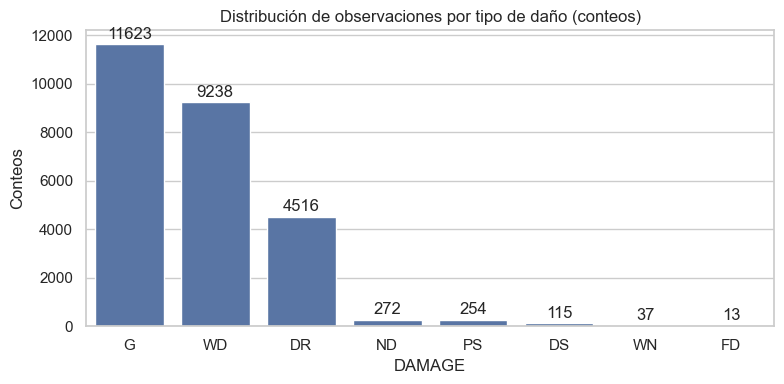

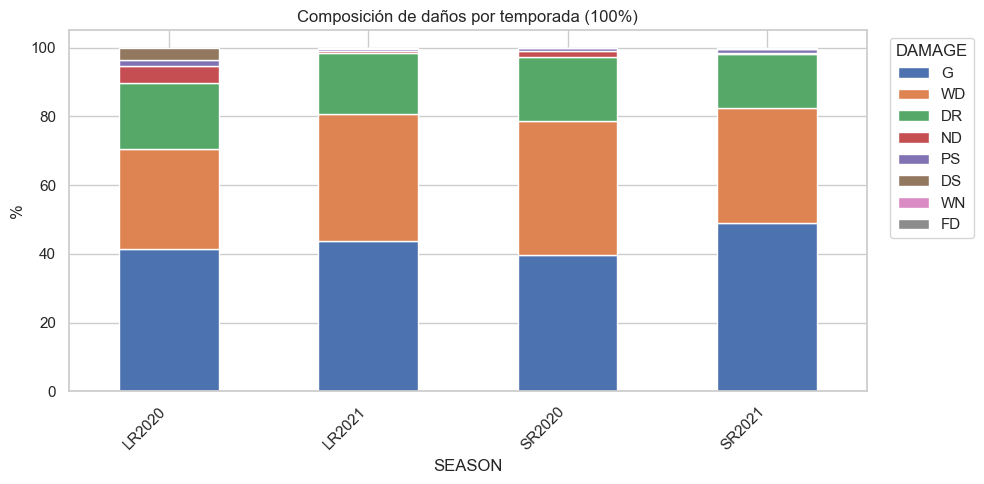

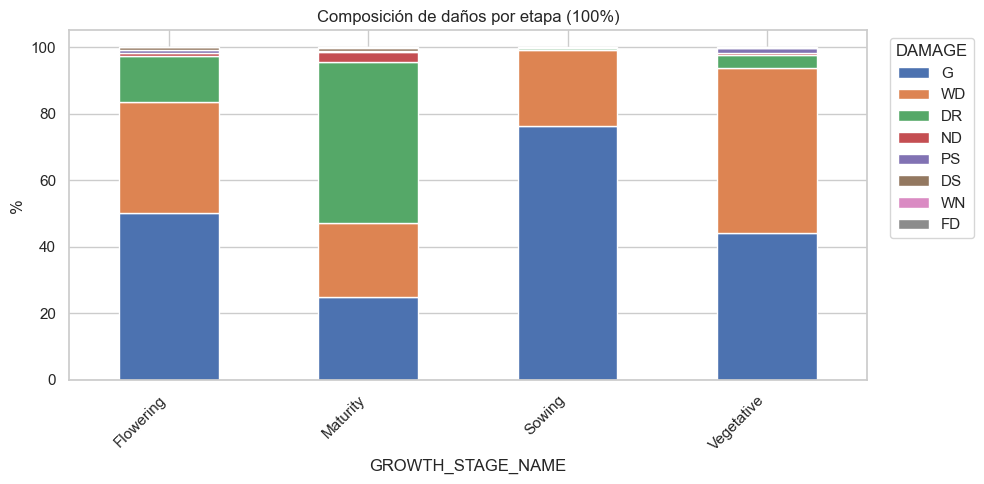

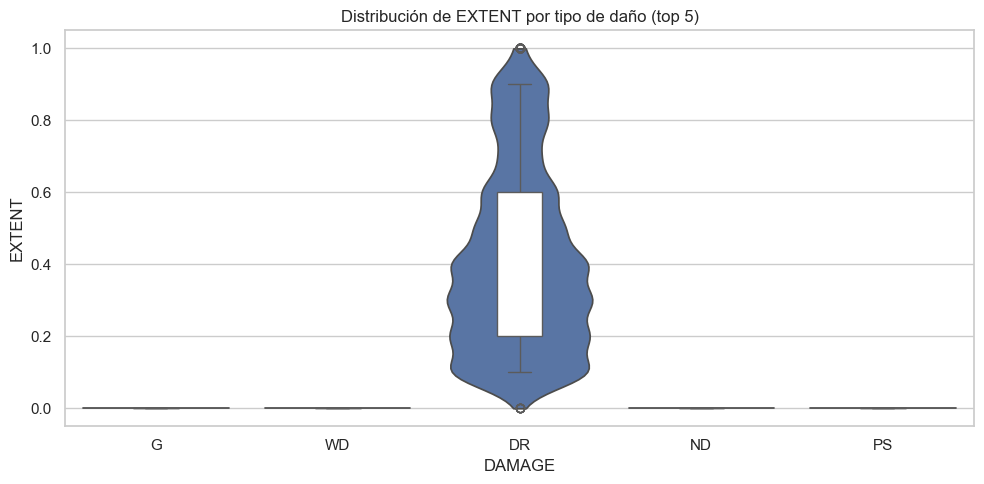

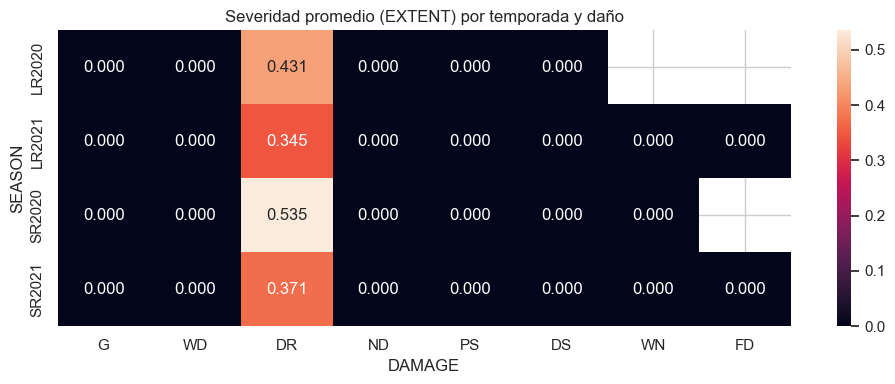

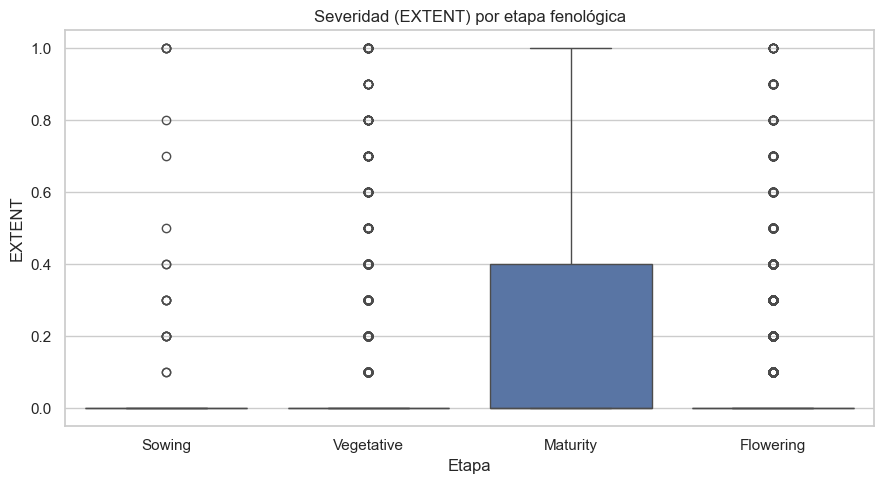

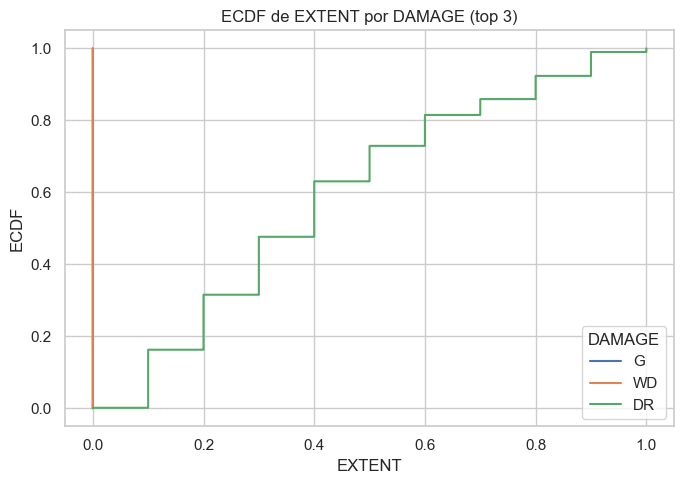

DR    0
DS    0
FD    0
G     0
ND    0
PS    0
WD    0
WN    0
Name: outliers_IQR, dtype: int64

TOP 10 outliers por EXTENT:


,ID,FILENAME,DAMAGE,SEASON,GROWTH_STAGE_NAME,EXTENT,Q1,Q3,IQR,LO,HI


Asociación SEASON ~ DAMAGE -> chi2=1130.0, p=5.175e-226, V de Cramér=0.120
Asociación GROWTH_STAGE_NAME ~ DAMAGE -> chi2=8209.3, p=0.000e+00, V de Cramér=0.324


In [23]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from scipy.stats import chi2_contingency

sns.set_theme(context="notebook", style="whitegrid")

df = TRAIN_CLEAN.copy()

# Orden de categorías de daño por frecuencia
order_damage = df["DAMAGE"].value_counts().index.tolist()

# --- A) Conteos y proporciones básicas de daño
plt.figure(figsize=(8,4))
ax = sns.countplot(data=df, x="DAMAGE", order=order_damage)
ax.bar_label(ax.containers[0], padding=2)
plt.title("Distribución de observaciones por tipo de daño (conteos)")
plt.xlabel("DAMAGE"); plt.ylabel("Conteos"); plt.tight_layout(); plt.show()

# --- B) Barras apiladas 100%: composición de daños por temporada/etapa
def stacked100(df, by, hue="DAMAGE", order=None, title=None, save=None):
    ct = pd.crosstab(df[by], df[hue], normalize="index")*100
    if order is not None:
        ct = ct.reindex(columns=order)
    ax = ct.plot(kind="bar", stacked=True, figsize=(10,5))
    plt.ylabel("%"); plt.title(title or f"Composición de {hue} por {by} (barras 100%)")
    plt.xticks(rotation=45, ha="right"); 
    plt.legend(bbox_to_anchor=(1.02,1), loc="upper left", title=hue)
    plt.tight_layout()
    if save: plt.savefig(OUTPUT_DIR/save, dpi=160)
    plt.show()
    return ct

ct_season = stacked100(df, "SEASON", order=order_damage, title="Composición de daños por temporada (100%)", save="stack_season_100.png")
ct_stage  = stacked100(df, "GROWTH_STAGE_NAME", order=order_damage, title="Composición de daños por etapa (100%)", save="stack_stage_100.png")

# --- C) Severidad por daño: violin + box (top 5)
top5 = order_damage[:5]
plt.figure(figsize=(10,5))
sns.violinplot(data=df[df["DAMAGE"].isin(top5)], x="DAMAGE", y="EXTENT", order=top5, inner=None, cut=0)
sns.boxplot(data=df[df["DAMAGE"].isin(top5)], x="DAMAGE", y="EXTENT", order=top5, whis=[5,95], width=0.25,
            showcaps=True, boxprops={"facecolor":"white","zorder":3})
plt.title("Distribución de EXTENT por tipo de daño (top 5)"); plt.tight_layout(); plt.show()

# --- D) Heatmap: severidad promedio por temporada × daño
pivot_s = df.pivot_table(values="EXTENT", index="SEASON", columns="DAMAGE", aggfunc="mean")
plt.figure(figsize=(10,4))
sns.heatmap(pivot_s.reindex(columns=order_damage), annot=True, fmt=".3f")
plt.title("Severidad promedio (EXTENT) por temporada y daño"); plt.tight_layout(); plt.show()

# --- E) Boxplot de EXTENT por etapa fenológica
plt.figure(figsize=(9,5))
sns.boxplot(data=df, x="GROWTH_STAGE_NAME", y="EXTENT")
plt.title("Severidad (EXTENT) por etapa fenológica"); plt.xlabel("Etapa"); plt.tight_layout(); plt.show()

# --- F) ECDF de EXTENT por daño (top 3)
def plot_ecdf(data, by, value, topn=3):
    top = data[by].value_counts().index[:topn]
    plt.figure(figsize=(7,5))
    for cat in top:
        x = np.sort(data.loc[data[by]==cat, value].values)
        y = np.arange(1, len(x)+1) / len(x)
        plt.step(x, y, where="post", label=cat)
    plt.xlabel(value); plt.ylabel("ECDF"); plt.title(f"ECDF de {value} por {by} (top {topn})")
    plt.legend(title=by); plt.tight_layout(); plt.show()
plot_ecdf(df, "DAMAGE", "EXTENT", topn=3)

# --- G) Outliers por daño (IQR) + top casos
def outliers_by_damage(df):
    resumen = {}
    detalles = []
    for dmg, g in df.groupby("DAMAGE"):
        x = g["EXTENT"].values
        q1, q3 = np.percentile(x, [25, 75])
        iqr = q3 - q1
        lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
        mask = (x < lo) | (x > hi)
        resumen[dmg] = int(mask.sum())
        if mask.any():
            detalles.append(g.loc[mask, ["ID","FILENAME","DAMAGE","SEASON","GROWTH_STAGE_NAME","EXTENT"]]
                              .assign(Q1=q1, Q3=q3, IQR=iqr, LO=lo, HI=hi))
    resumen = pd.Series(resumen, name="outliers_IQR").sort_values(ascending=False)
    display(resumen)
    if detalles:
        detalles = pd.concat(detalles, ignore_index=True).sort_values("EXTENT", ascending=False)
    else:
        detalles = pd.DataFrame(columns=["ID","FILENAME","DAMAGE","SEASON","GROWTH_STAGE_NAME","EXTENT","Q1","Q3","IQR","LO","HI"])
    return resumen, detalles

out_counts, out_details = outliers_by_damage(df)
print("TOP 10 outliers por EXTENT:"); display(out_details.head(10))

# --- H) Asociación categórica: Chi² y V de Cramér (DAMAGE ~ SEASON / GROWTH_STAGE_NAME)
def cramers_v(tab):
    chi2, p, dof, exp = chi2_contingency(tab)
    n = tab.to_numpy().sum()
    r, k = tab.shape
    v = np.sqrt(chi2/(n*(min(r-1, k-1))))
    return chi2, p, v

for by in ["SEASON","GROWTH_STAGE_NAME"]:
    tab = pd.crosstab(df[by], df["DAMAGE"])
    chi2, p, v = cramers_v(tab)
    print(f"Asociación {by} ~ DAMAGE -> chi2={chi2:.1f}, p={p:.3e}, V de Cramér={v:.3f}")


## Descripciones de las gráficas (Markdown listo para pegar)

**a) Distribución de observaciones por tipo de daño (conteos)**

**Qué veo.** La distribución está muy desbalanceada: G (11,623) y WD (9,238) concentran ~80% de los registros; DR (4,516) ocupa el tercer lugar. Las demás (ND, PS, DS, WN, FD) representan menos del 2% combinadas.

**Interpretación.** Este desbalance exige, para fases de modelado, métricas macro y/o ponderación de clases (class weights / muestreos). También sugiere revisar estrategias de augmentación para clases minoritarias.

**b) Composición de daños por temporada**

**Qué veo.** La proporción de cada daño cambia entre LR2020, LR2021, SR2020 y SR2021. A simple vista, G y WD dominan todas las temporadas, pero DR aumenta su peso en SR2020, lo cual es consistente con la severidad media observada más adelante.

****Interpretación.**** Hay dependencia temporal en la composición de daños. Cuidaré la validación estratificada por SEASON para evitar leakage.

**c) Composición de daños por etapa fenológica**

**Qué veo.** Las proporciones varían por etapa. En Vegetative y Flowering predominan G y WD; en Maturity crece notablemente la proporción de DR. Sowing muestra una composición todavía más concentrada, con fuerte peso de G.

**Interpretación.** Hay asociación moderada entre DAMAGE y GROWTH_STAGE_NAME (lo confirmo con V de Cramér ≈ 0.324). Esto justifica usar la etapa fenológica como covariable/clúster en fases posteriores.

**d) Distribución de EXTENT por tipo de daño**

**Qué veo.** Para G, WD, ND, PS los valores de EXTENT se concentran cerca de 0; en cambio DR presenta una distribución con amplio rango (hasta 1.0) y mediana claramente por encima de 0.

**Interpretación.** La severidad (cuando existe) se concentra en DR. Para el resto de daños, el porcentaje de ceros domina, lo que sugiere esparsidad o que EXTENT solo se reporta >0 en pocos casos.

**e) Heatmap — severidad promedio (EXTENT) por temporada y daño**

**Qué veo.** Prácticamente solo DR tiene severidad media distinta de 0; por temporada: LR2020 ≈ 0.431, LR2021 ≈ 0.345, SR2020 ≈ 0.535 (la mayor) y SR2021 ≈ 0.371.

**Interpretación.** La severidad promedio está concentrada en DR y varía con la temporada, con pico en SR2020. Esto refuerza la lectura de (b).

**f) Boxplot — EXTENT por etapa fenológica**

**Qué veo.** En Maturity la variabilidad de EXTENT es mucho mayor (se observan varios puntos cercanos a 1.0). En Sowing, Vegetative y Flowering la mayoría están pegados a 0.

**Interpretación.** Maturity concentra casos más severos; esto cuadra con la mayor presencia relativa de DR en esa etapa.

**g) ECDF de EXTENT por DAMAGE**

**Qué veo.** Las curvas de G y WD suben de inmediato en 0 (casi todos los valores son 0), mientras que DR crece gradualmente hasta 1.0.

**Interpretación.** Confirma el patrón de casi-todo-cero en G/WD y distribución extendida de severidad en DR. Es evidencia clara de esparsidad.

**h) Asociación categórica (Chi² y V de Cramér)**

**Qué veo.** SEASON ~ DAMAGE: χ²=1130.0, p≈5.18e-226, V=0.120 (efecto pequeño).
GROWTH_STAGE_NAME ~ DAMAGE: χ²=8209.3, p<1e-15, V=0.324 (efecto moderado).

**Interpretación.** Con muestras grandes es normal obtener p-valores muy pequeños; el tamaño de efecto es el que manda: etapa explica más variación en DAMAGE que temporada.

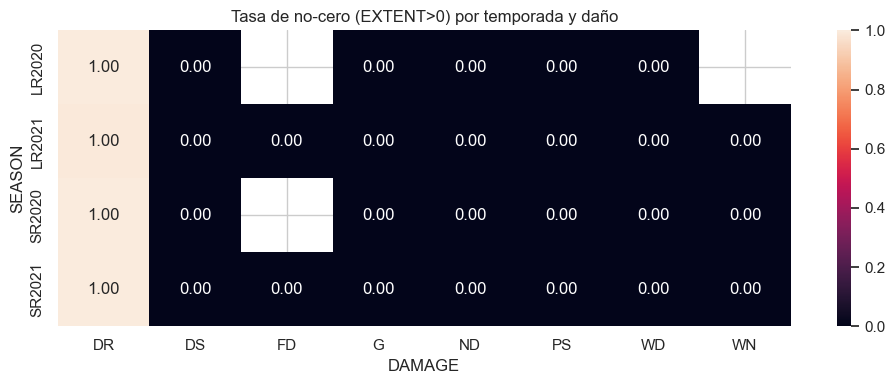

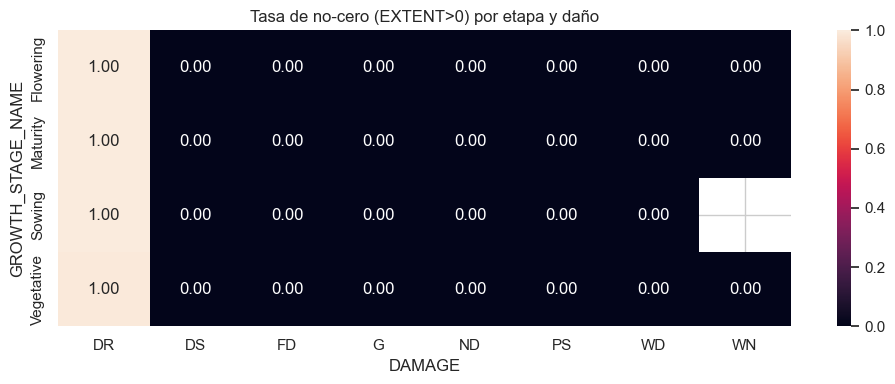

In [24]:
# Tasa de no-cero por temporada × daño
tab_nz_season = (TRAIN_CLEAN.assign(NZ=lambda d: (d["EXTENT"]>0).astype(int))
                 .pivot_table(values="NZ", index="SEASON", columns="DAMAGE", aggfunc="mean"))
plt.figure(figsize=(10,4))
sns.heatmap(tab_nz_season, annot=True, fmt=".2f")
plt.title("Tasa de no-cero (EXTENT>0) por temporada y daño")
plt.tight_layout(); plt.show()

# Tasa de no-cero por etapa × daño
tab_nz_stage = (TRAIN_CLEAN.assign(NZ=lambda d: (d["EXTENT"]>0).astype(int))
                .pivot_table(values="NZ", index="GROWTH_STAGE_NAME", columns="DAMAGE", aggfunc="mean"))
plt.figure(figsize=(10,4))
sns.heatmap(tab_nz_stage, annot=True, fmt=".2f")
plt.title("Tasa de no-cero (EXTENT>0) por etapa y daño")
plt.tight_layout(); plt.show()


**f) Tasa de no-cero (EXTENT>0) por temporada × daño**

**Qué veo.** En el heatmap la columna DR aparece con 1.00 en todas las temporadas (LR2020, LR2021, SR2020, SR2021), mientras que el resto de daños (G, WD, ND, PS, WN, FD, DS) están en 0.00. Las celdas en blanco indican temporadas donde no hubo registros de esa categoría (por eso la tasa queda indefinida).

**Interpretación.** En mi conjunto, solo DR presenta severidad positiva (EXTENT>0), y todos sus registros son no-cero. El resto de daños aparecen con severidad 0. Esto confirma una esparsidad extrema y que la severidad útil para modelar está concentrada exclusivamente en DR. Para el modelado, tiene sentido tratar DR como regresión de severidad, y el resto como presencia/ausencia

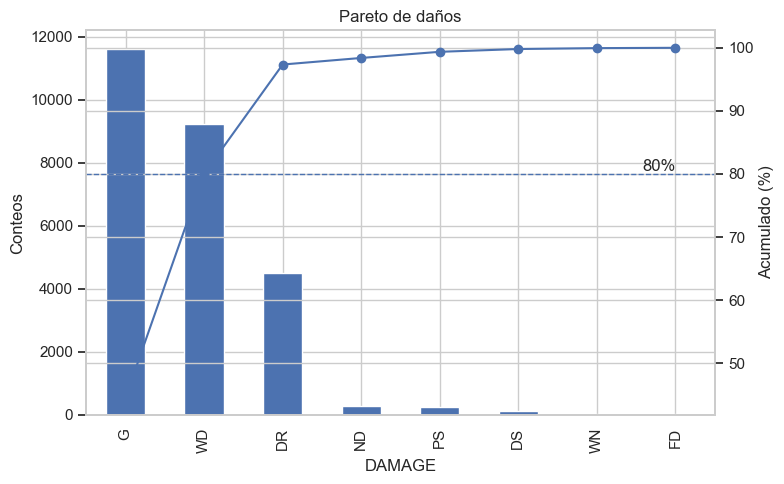

In [25]:
vc = TRAIN_CLEAN["DAMAGE"].value_counts()
pareto = vc.cumsum()/vc.sum()*100
fig, ax1 = plt.subplots(figsize=(8,5))
vc.plot(kind="bar", ax=ax1)
ax1.set_ylabel("Conteos"); ax1.set_title("Pareto de daños")
ax2 = ax1.twinx()
pareto.plot(ax=ax2, style="-o"); ax2.set_ylabel("Acumulado (%)")
ax2.axhline(80, ls="--", lw=1); ax2.text(len(vc)-1, 80.5, "80%", ha="right")
plt.tight_layout(); plt.show()


**g) Pareto de daños**

**Qué veo.** El gráfico de Pareto muestra que con solo dos daños (G + WD) ya alcanzo el ~80% de las observaciones, y al añadir DR llego a ~97% del total.

**Interpretación.** El desbalance es muy alto: tres categorías (G, WD, DR) explican ~97% del conjunto, dejando al resto por debajo del 3%. Para cualquier modelo de clasificación, debo estratificar/ponderar y reportar métricas macro (macro-F1, balanced accuracy). Para comunicación, este Pareto deja clarísima la concentración.

# RESÚMENES PROGRAMÁTICOS Y HALLAZGOS

In [22]:
# resumen de hallazgos
def RESUMEN_HALLAZGOS(TRAIN: pd.DataFrame):
    LBL = TRAIN.attrs.get("LABEL_COLS", [])
    LBL = [c for c in LBL if c in TRAIN.columns]

    LINEAS = []
    LINEAS.append("## 6. Conclusiones – Hallazgos principales\n")

    # faltantes
    MISS = TRAIN.isna().sum()
    MISS = MISS[MISS>0].sort_values(ascending=False)
    if not MISS.empty:
        TOP_MISS = MISS.head(8).to_dict()
        LINEAS.append("**Valores faltantes (top):** " + ", ".join([f"{k}: {v}" for k,v in TOP_MISS.items()]))

    # distribuciones
    if "SEASON" in TRAIN.columns:
        SEASON_VC = TRAIN["SEASON"].value_counts(dropna=False).to_dict()
        LINEAS.append("**Distribución por temporada:** " + ", ".join([f"{k}: {v}" for k,v in SEASON_VC.items()]))

    if "GROWTH_STAGE" in TRAIN.columns:
        STAGE_VC = TRAIN["GROWTH_STAGE"].value_counts(dropna=False).to_dict()
        LINEAS.append("**Distribución por etapa:** " + ", ".join([f"{k}: {v}" for k,v in STAGE_VC.items()]))

    # daño dominante
    if "DOMINANT_DAMAGE" in TRAIN.columns:
        DOM_VC = TRAIN["DOMINANT_DAMAGE"].value_counts(dropna=False).to_dict()
        LINEAS.append("**Daño dominante (conteos):** " + ", ".join([f"{k}: {v}" for k,v in DOM_VC.items()]))

    # estadísticas de etiquetas
    if LBL:
        MEANS = TRAIN[LBL].mean().sort_values(ascending=False).to_dict()
        LINEAS.append("**Promedios de extensión por etiqueta (mayor→menor):** " + ", ".join([f"{k}: {round(v,2)}%" for k,v in MEANS.items()]))

    TEXTO = "\n".join(LINEAS)
    print(TEXTO)

RESUMEN_HALLAZGOS(TRAIN_CLEAN)


## 6. Conclusiones – Hallazgos principales

**Distribución por temporada:** SR2021: 9927, LR2021: 7945, SR2020: 6163, LR2020: 2033
**Promedios de extensión por etiqueta (mayor→menor):** EXTENT: 0.07%


## 6. Hallazgos y conclusiones

**Calidad y estructura.** Confirmé que los metadatos (`SEASON`, `GROWTH_STAGE`) están estandarizados y que las etiquetas de daño están en el esquema long (una fila por imagen: `DAMAGE` + `EXTENT`). Tras la limpieza no quedaron **valores faltantes** y el *dataset* final tiene **26,068** filas. En `EXTENT` observé media **0.071** (≈ **7.10%**), desviación estándar **0.186** (≈ **18.61%**), **mediana 0.0** y **Q3 = 0.0**, es decir, **distribución muy sesgada** con abundancia de ceros. Detecté **45 outliers** entre los valores distintos de cero (percentil 95).  
**Chequeo clave:** la **tasa de no-cero (EXTENT>0)** por temporada y por etapa es **1.00 exclusivamente para `DR`** y **0.00** para el resto de daños (con celdas vacías cuando no hay registros). Esto confirma que la severidad útil está concentrada **solo en `DR`**.

**Patrones principales.**  
- **Temporada (conteos / %):** SR2021 **9,927 (38.08%)**, LR2021 **7,945 (30.48%)**, SR2020 **6,163 (23.64%)**, LR2020 **2,033 (7.80%)** (predomina 2021).  
- **Etapa (conteos / %):** `Vegetative` **10,015 (38.42%)**, `Maturity` **6,664 (25.56%)**, `Flowering` **6,164 (23.65%)**, `Sowing` **3,225 (12.37%)**.  
- **Categoría de daño (conteos / %):** `G` **11,623 (44.59%)**, `WD` **9,238 (35.44%)**, `DR` **4,516 (17.32%)**, resto < **1.1%** cada uno.  
- **Pareto:** `G+WD` explican ~**80%** del total; **`G+WD+DR` ~97%**.  
- **Severidad:** el *heatmap* de severidad media por temporada muestra **valores >0 solo en `DR`** (máximo en **SR2020 ~0.535**). Por etapa, `Maturity` exhibe **mayor variabilidad** y presencia de casos severos (outliers).  
- **Asociación categórica:** `SEASON ~ DAMAGE` (V de Cramér ≈ **0.120**, efecto pequeño); `GROWTH_STAGE_NAME ~ DAMAGE` (V ≈ **0.324**, efecto moderado).

**Implicaciones.**  
1) El problema es **multiclase muy desbalanceado**: debo **estratificar** por `SEASON` y `GROWTH_STAGE`, usar **class weights**/muestreos y reportar **macro-F1**.  
2) Dado que `EXTENT>0` se observa **solo en `DR`**, el modelado de severidad tiene sentido **exclusivamente para `DR`** (regresión o clasificación ordinal). Para el resto de daños, si se requiere, trataría la variable como **presencia/ausencia** (pero la severidad es 0).  
3) Las diferencias por temporada/etapa indican posible **heterogeneidad**; conviene **validación estratificada** para evitar *leakage* temporal/fenológico y asegurar generalización.

**Siguientes pasos.**  
- **Vista por imagen (wide)**: pivotear a `DR…WN` para analizar **co-ocurrencias** y verificar sumas por imagen (≈100) cuando aplique.  
- **Modelo base**: (i) clasificador de daño con **class weights**; (ii) **regresor de severidad para `DR`**.  
- **Métricas**: macro-F1 / balanced accuracy para clasificación; MAE/MSE para severidad de `DR`.  
- **Explicabilidad**: aplicar SHAP y validar que las señales coinciden con el criterio agronómico por etapa/temporada.


## Referencias

- Science, S. (2025, September 10). Bacterias y Enfermedades de las Plantas: Entendiendo la Amenaza. Simple Science. https://scisimple.com/es/articles/2025-09-10-bacterias-y-enfermedades-de-las-plantas-entendiendo-la-amenaza--akg4jeg
- Díaz, I. (2025, August 30). Efectos de la Contaminación en los Cultivos: Impacto y Soluciones. Ecología Digital. https://ecologiadigital.bio/los-efectos-de-la-contaminacion-en-los-cultivos/
- Gómez, P. (2025, September 14). Relación entre hongos y enfermedades en las plantas. Todo Micología. https://todomicologia.com/fisiologia/relacion-entre-hongos-y-enfermedades-en-las-plantas/

